In [5]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from pymannkendall import original_test
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

In [6]:
pio.templates.default = "plotly_white"

In [7]:
data_file_location = 'data/'
os.makedirs(data_file_location, exist_ok=True)

result_file_location = 'results/'
os.makedirs(result_file_location, exist_ok=True)

In [8]:
def save_plot(fig, folder, filename, extensions=['png', 'svg', 'pdf'], scale=2):
    for ext in extensions:
        fig.write_image(folder + filename + '.' + ext, scale=scale)

# Largest training runs for leading companies

In [9]:
company_aliases = {
    "Google": "Google",
    "Google Research": "Google",
    "Google Brain": "Google",
    "Google Inc.": "Google",
    "Google AI, Brain team": "Google",
    "Google Research, Brain Team": "Google",
    "Google AI": "Google",
    "Google Brain,Google Research": "Google",
    "Google Inc": "Google",
    "DeepMind": "DeepMind",
    "Google DeepMind": "DeepMind",
    "Meta AI": "Meta",
    "MetaAI": "Meta",
    "Facebook AI Research": "Meta",
    "Facebook AI research": "Meta",
    "Facebook": "Meta",
    "Facebook AI": "Meta",
    "OpenAI": "OpenAI",
    "Open AI": "OpenAI",
    "Microsoft Research": "Microsoft",
    "Microsoft": "Microsoft",
    "Microsoft Research,Peking University": "Microsoft",
    "Microsoft Bing": "Microsoft",
    "Alibaba Group": "Alibaba",
    "Alibaba": "Alibaba",
    "NVIDIA": "NVIDIA",
    "Nvidia": "NVIDIA",
    "Baidu Research- Silicon Valley AI Lab": "Baidu",
    "Baidu": "Baidu",
    "Amazon": "Amazon",
    "Anthropic": "Anthropic",
    "IBM": "IBM",
    "Huawei Noah's Ark Lab": "Huawei",
    "Intel Labs": "Intel",
    "NAVER": "Naver",
    "Xerox Research Centre Europe": "Xerox",
    "Yandex": "Yandex",
    "Salesforce research": "Salesforce",
}

- Sort by publication date
- Filter companies of interest + rename companies to consistent alias => new DataFrame
- Get the maximum envelope of the data => new DataFrame
- Add on the last maximum to the current date, so there's a horizontal line continuing until the current date

In [10]:
# Use snapshot (for reproducibility)
df = pd.read_csv(data_file_location + "PCD_ALL_ML_SYSTEMS_snapshot_2023-11-01.csv")

# Use live dataset
# sheet_id = '1AAIebjNsnJj_uKALHbXNfn3_YsT6sHXtCU0q7OIPuc4'
# data_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet='
# df = pd.read_csv(data_url + 'ALL%20ML%20SYSTEMS')

In [11]:
cols_of_interest = ["System", "Organization", "Publication date", "Training compute (FLOP)"]

In [12]:
df = df.dropna(subset=["Organization", "Training compute (FLOP)"])

In [13]:
# Rejected samples
# We don't think the full training run was actually done
df.drop(df[df["System"] == "Megatron-LM (1T)"].index, inplace=True)
# Kingma was affiliated with OpenAI on the paper for this system, but only in the 2017 version rather than the original 2014 version
df.drop(df[df["System"] == "ADAM (CIFAR-10)"].index, inplace=True)


In [14]:
df['Publication date'] = pd.to_datetime(df['Publication date'])  # Ensure date column is in datetime format

In [15]:
df.sort_values('Publication date', inplace=True)
df.reset_index(inplace=True)

In [16]:
# Drop publication dates before 2012
df.drop(df[df['Publication date'] < datetime(2012, 1, 1)].index, inplace=True)

In [17]:
df[cols_of_interest]

,System,Organization,Publication date,Training compute (FLOP)
27,MCDNN (MNIST),IDSIA,2012-02-13,3.730000e+15
28,Dropout (MNIST),University of Toronto,2012-06-03,6.040000e+15
29,Dropout (ImageNet),University of Toronto,2012-06-03,2.730000e+17
30,Dropout (CIFAR),University of Toronto,2012-06-03,4.270000e+15
31,Unsupervised High-level Feature Learner,Google,2012-07-12,6.000000e+17
...,...,...,...,...
196,Jais,"Cerebras Systems,Mohamed bin Zayed University ...",2023-08-29,3.080000e+22
197,Swift,Intel Labs,2023-08-30,5.340000e+16
198,Falcon 180B,Technology Innovation Institute,2023-09-06,3.780000e+24
199,StableLM-3B-4E1T,Stability AI,2023-09-29,6.210000e+22


## Filter companies of interest + rename companies to consistent alias

In [18]:
rows = []
for i, row in df.iterrows():
    orgs = row["Organization"]
    print(orgs)
    org_list = [org.strip() for org in orgs.split(",")]
    for org in org_list:
        if org in company_aliases.keys():
            alias = company_aliases[org]
            new_row = row.copy()
            new_row["Organization"] = alias
            rows.append(new_row)

company_df = pd.DataFrame(rows)
company_df[cols_of_interest]

IDSIA
University of Toronto
University of Toronto
University of Toronto
Google
University of Toronto
Universidad Nacional de Cordoba,Xerox Research Centre Europe,Inteligent Systems Lab Amsterdam,University of Amsterdam,LEAR Team,INRIA
IDSIA
Google
New York University
CNRS,Google
DeepMind
Univeristy of Amsterdam
Universite de Montréal
Microsoft,Xi’an Jiaotong University,University of Science and Technology of China
University College London
Universite de Montréal,Jacobs University Bremen
University of Oxford
Google
Microsoft Research
Google,University of Michigan,University of North Carolina
Google DeepMind
Baidu Research- Silicon Valley AI Lab
Microsoft
DeepMind
Tsinghua University,Microsoft Research
University of Toronto
University of Toronto
Google
Google
Google Brain
The Chinese University of Hong Kong
DeepMind
Carnegie Mellon University
University of Alberta,Charles University,Czech Technical University
Jagiellonian University,Google Brain
Google Research,Google Brain
Google Resear

,System,Organization,Publication date,Training compute (FLOP)
31,Unsupervised High-level Feature Learner,Google,2012-07-12,6.000000e+17
33,Image Classification with the Fisher Vector: T...,Xerox,2013-06-12,9.080000e+13
35,Word2Vec (large),Google,2013-10-16,3.890000e+16
37,TransE,Google,2013-12-05,1.340000e+18
38,DQN,DeepMind,2013-12-19,2.300000e+15
...,...,...,...,...
194,RetNet,Microsoft,2023-07-17,4.020000e+21
195,Llama 2,Meta,2023-07-18,8.100000e+23
197,Swift,Intel,2023-08-30,5.340000e+16
200,CODEFUSION (Python),Microsoft,2023-10-26,7.920000e+18


In [19]:
company_max_compute_df = company_df.copy()

In [20]:
company_max_compute_df["Training compute (FLOP)"] = company_df.groupby("Organization")['Training compute (FLOP)'].cummax()
company_max_compute_df[cols_of_interest]

,System,Organization,Publication date,Training compute (FLOP)
31,Unsupervised High-level Feature Learner,Google,2012-07-12,6.000000e+17
33,Image Classification with the Fisher Vector: T...,Xerox,2013-06-12,9.080000e+13
35,Word2Vec (large),Google,2013-10-16,6.000000e+17
37,TransE,Google,2013-12-05,1.340000e+18
38,DQN,DeepMind,2013-12-19,2.300000e+15
...,...,...,...,...
194,RetNet,Microsoft,2023-07-17,1.170000e+24
195,Llama 2,Meta,2023-07-18,8.100000e+23
197,Swift,Intel,2023-08-30,5.340000e+16
200,CODEFUSION (Python),Microsoft,2023-10-26,1.170000e+24


In [21]:
rows_to_add = []
current_max_compute = {}
for org, group_data in company_max_compute_df.groupby("Organization"):
    print(org, group_data["Training compute (FLOP)"].max())
    current_max_compute[org] = group_data["Training compute (FLOP)"].max()
    
    current_date = datetime.now().date()  # Get the current date
    compute = group_data["Training compute (FLOP)"].max()
    # Create a new row with NaN for all columns except "Organization", "Publication date", and "Training compute (FLOP)"
    new_row = pd.Series(
        {
            "Organization": org,
            "Publication date": current_date,
            "Training compute (FLOP)": compute,
        }
    )
    rows_to_add.append(new_row)

# Create a DataFrame from the rows to be added
new_data = pd.DataFrame(rows_to_add)

# Concatenate the new_data DataFrame to the original filtered_df
company_max_compute_df = pd.concat([company_max_compute_df, new_data], ignore_index=True)

Alibaba 3.6e+22
Amazon 2.04e+23
Anthropic 3.87e+24
Baidu 1.04e+24
DeepMind 6.31e+23
Google 7.34e+24
Huawei 4.67e+23
IBM 1.78e+21
Intel 5.34e+16
Meta 8.1e+23
Microsoft 1.17e+24
NVIDIA 1.17e+24
Naver 1.48e+23
OpenAI 2.1e+25
Salesforce 3.7e+20
Xerox 90800000000000.0
Yandex 2.2e+23


In [22]:
top10 = []
for company, compute in sorted(current_max_compute.items(), key=lambda x: x[1], reverse=True):
    print(company, compute)
    if len(top10) < 10:
        top10.append(company)

OpenAI 2.1e+25
Google 7.34e+24
Anthropic 3.87e+24
Microsoft 1.17e+24
NVIDIA 1.17e+24
Baidu 1.04e+24
Meta 8.1e+23
DeepMind 6.31e+23
Huawei 4.67e+23
Yandex 2.2e+23
Amazon 2.04e+23
Naver 1.48e+23
Alibaba 3.6e+22
IBM 1.78e+21
Salesforce 3.7e+20
Intel 5.34e+16
Xerox 90800000000000.0


In [23]:
company_max_compute_df

,index,System,Domain,Task,Organization,Organization Categorization,Authors,Publication date,Reference,Link,...,Training time notes,Training hardware,Approach,Training compute cost (2020 USD),Compute cost notes,Self-supervised training,Compute Sponsor Categorization,Confidence,Abstract,Last Modified
0,379.0,Unsupervised High-level Feature Learner,Vision,Image classification,Google,Industry,"Quoc V. Le, Marc'Aurelio Ranzato, Rajat Monga,...",2012-07-12 00:00:00,Building High-level Features Using Large Scale...,https://arxiv.org/abs/1112.6209,...,"""We train this network using model parallelism...",NaN,Unsupervised,NaN,Hardware not reported,NaN,Industry,Likely,We consider the problem of building high-level...,2023-09-20 19:59:11
1,368.0,Image Classification with the Fisher Vector: T...,Vision,Image Classification,Xerox,Industry - Academia Collaboration,"orge Sanchez, Florent Perronnin, Thomas Mensin...",2013-06-12 00:00:00,Image Classification with the Fisher Vector: T...,https://hal.inria.fr/hal-00830491v2/document,...,NaN,NaN,NaN,0.00141,NaN,NaN,NaN,NaN,NaN,2023-09-27 16:26:02
2,365.0,Word2Vec (large),Language,Semantic embedding,Google,Industry,"T Mikolov, I Sutskever, K Chen, GS Corrado",2013-10-16 00:00:00,Distributed Representations of Words and Phras...,https://arxiv.org/abs/1310.4546,...,NaN,NaN,NaN,0.54800,NaN,NaN,Industry,NaN,NaN,2023-10-30 18:45:57
3,361.0,TransE,Other,Entity embedding,Google,Industry - Academia Collaboration,"Antoine Bordes, Nicolas Usunier, Alberto Garci...",2013-12-05 00:00:00,Translating Embeddings for Modeling Multi- rel...,https://papers.nips.cc/paper/2013/hash/1cecc7a...,...,NaN,NaN,NaN,17.60000,NaN,NaN,Industry,Speculative,NaN,2023-10-17 14:24:13
4,358.0,DQN,Games,Atari,DeepMind,Industry,"V Mnih, K Kavukcuoglu, D Silver, A Graves",2013-12-19 00:00:00,Playing Atari with Deep Reinforcement Learning,https://arxiv.org/abs/1312.5602,...,NaN,NaN,NaN,0.04040,NaN,NaN,Industry,NaN,NaN,2023-10-30 18:46:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,NaN,NaN,NaN,NaN,Naver,NaN,NaN,2023-11-01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,NaN,NaN,NaN,NaN,OpenAI,NaN,NaN,2023-11-01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,NaN,NaN,NaN,NaN,Salesforce,NaN,NaN,2023-11-01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,NaN,NaN,NaN,NaN,Xerox,NaN,NaN,2023-11-01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
company_max_compute_df[cols_of_interest]

,System,Organization,Publication date,Training compute (FLOP)
0,Unsupervised High-level Feature Learner,Google,2012-07-12 00:00:00,6.000000e+17
1,Image Classification with the Fisher Vector: T...,Xerox,2013-06-12 00:00:00,9.080000e+13
2,Word2Vec (large),Google,2013-10-16 00:00:00,6.000000e+17
3,TransE,Google,2013-12-05 00:00:00,1.340000e+18
4,DQN,DeepMind,2013-12-19 00:00:00,2.300000e+15
...,...,...,...,...
141,NaN,Naver,2023-11-01,1.480000e+23
142,NaN,OpenAI,2023-11-01,2.100000e+25
143,NaN,Salesforce,2023-11-01,3.700000e+20
144,NaN,Xerox,2023-11-01,9.080000e+13


In [25]:
current_max = 0
current_max_org = "Google"
global_max_rows = []
for i, row in company_max_compute_df.iterrows():
    if row["Training compute (FLOP)"] > current_max:
        current_max = row["Training compute (FLOP)"]
        if row["Organization"] != current_max_org:
            current_max_org = row["Organization"]
            global_max_rows.append(row)
global_max_df = pd.DataFrame(global_max_rows)
global_max_df[cols_of_interest]

,System,Organization,Publication date,Training compute (FLOP)
5,SPPNet,Microsoft,2014-06-18,3.410000e+18
6,Seq2Seq LSTM,Google,2014-09-10,5.600000e+19
9,AlphaGo Fan,DeepMind,2015-10-01,3.800000e+20
14,GNMT,Google,2016-09-26,6.900000e+21
17,AlphaGo Master,DeepMind,2017-01-01,1.500000e+23
91,Megatron-Turing NLG 530B,Microsoft,2021-10-11,1.170000e+24
103,PaLM (540B),Google,2022-04-04,2.530000e+24
120,GPT-4,OpenAI,2023-03-15,2.100000e+25


In [34]:
# Create a line plot
fig = px.line(
    company_max_compute_df[company_max_compute_df["Organization"].isin(top10)],
    x="Publication date",
    y="Training compute (FLOP)",
    line_shape="hv",
    color="Organization",
    labels={"Training compute (FLOP)": "Largest estimated training run to date (FLOP)"},
    category_orders={"Organization": ["Google", "Microsoft", "DeepMind", "Baidu", "Meta", "OpenAI", "NVIDIA", "Huawei", "Yandex", "Anthropic"]},
    hover_data=["System"],
)
fig.add_trace(
    go.Scatter(
        x=global_max_df["Publication date"],
        y=global_max_df["Training compute (FLOP)"],
        text=global_max_df["System"],
        textposition="top left",
        line={"color": "black"},
        marker_symbol="triangle-up",
        mode="markers+text",
        name="Changes in leader",
    )
)
fig.add_trace(
    go.Scatter(
        x=pd.to_datetime(["2020-05-28", "2023-07-18", "2023-07-11"]),
        y=[3.14e23, 8.1e23, 3.87e24],
        text=["GPT-3", " LLaMA 2", " Claude 2"],
        textposition=["top left", "middle right", "middle right"],
        line={"color": "black"},
        mode="markers+text",
        marker_symbol="star",
        name="Other notable systems",
    )
)

# Convert year to datetime
fig.update_yaxes(type="log")
# Show all years on x axis
fig.update_xaxes(nticks=12)
# Make sure the labels are fully shown
fig.update_xaxes(range=[pd.to_datetime(2011, format="%Y"), pd.to_datetime('2025-06-01', format="%Y-%m-%d")])# datetime.now().date()])
fig.update_layout(
    legend=dict(
        title="",
        orientation="h",
        # yanchor="top",
        y=-0.15,
        # xanchor="center",
        x=0,
    ),
)
# Edit figure layout
fig.update_layout(
    autosize=False,
    width=480,
    height=400,
    font=dict(size=10),
    margin=dict(l=20, r=20, t=20, b=0),
)

save_plot(fig, result_file_location, 'companies_largest_compute_all')

fig.show()

# Regression

In [21]:
# Explicitly make a copy
df2 = company_max_compute_df[company_max_compute_df["Organization"].isin(["Google", "DeepMind", "OpenAI", "Meta", "Microsoft"])].copy()

# Convert to datetime and extract Year
df2['Publication date'] = pd.to_datetime(df2['Publication date'])
df2['Year'] = df2['Publication date'].dt.year

# Log transform the compute column
df2['log_compute'] = np.log10(df2['Training compute (FLOP)'])

# Sort DataFrame by 'Publication date'
df2 = df2.sort_values('Publication date')

# Calculate the running maximum for 'log_compute'
df2['cumulative_max'] = df2['log_compute'].cummax()

# Calculate the squared difference
df2['concentration'] = (df2['log_compute'] - df2['cumulative_max'])
df2.loc[df2['concentration'] == 0, 'concentration'] = np.nan
# df2.loc[df2['concentration'] < -4, 'concentration'] = np.nan #Check robustness to four very low values


In [22]:
df2['cumulative_max']

0      17.778151
1      17.778151
2      18.127105
3      18.127105
4      18.532754
         ...    
113    25.322219
114    25.322219
115    25.322219
116    25.322219
118    25.322219
Name: cumulative_max, Length: 108, dtype: float64

In [23]:
# Convert 'Publication date' to ordinal day number
df2['Publication_ordinal'] = df2['Publication date'].apply(lambda x: x.toordinal())

# Prepare the features (X) and target (y) variables
X = df2[['Publication_ordinal']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df2['concentration']

# Drop rows with NaN in 'y' or any of the columns in 'X'
valid_rows = y.notna() & X.notna().all(axis=1)
y = y[valid_rows]
X = X.loc[valid_rows]

# Run the regression model
model = sm.OLS(y, X)
results = model.fit()

# Show summary statistics of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          concentration   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     13.81
Date:                Fri, 13 Oct 2023   Prob (F-statistic):           0.000391
Time:                        15:28:20   Log-Likelihood:                -94.430
No. Observations:                  76   AIC:                             192.9
Df Residuals:                      74   BIC:                             197.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -354.3252    

In [24]:
results.params[1] * 365

0.174747449436573

In [25]:
results.conf_int()[0] * 365

const                 -198450.468944
Publication_ordinal         0.081035
Name: 0, dtype: float64

In [26]:
preds = results.predict(X)
preds

3     -2.330676
6     -2.132470
10    -1.985490
12    -1.892611
17    -1.789199
         ...   
110   -0.655973
113   -0.614321
114   -0.614321
115   -0.614321
116   -0.614321
Length: 76, dtype: float64

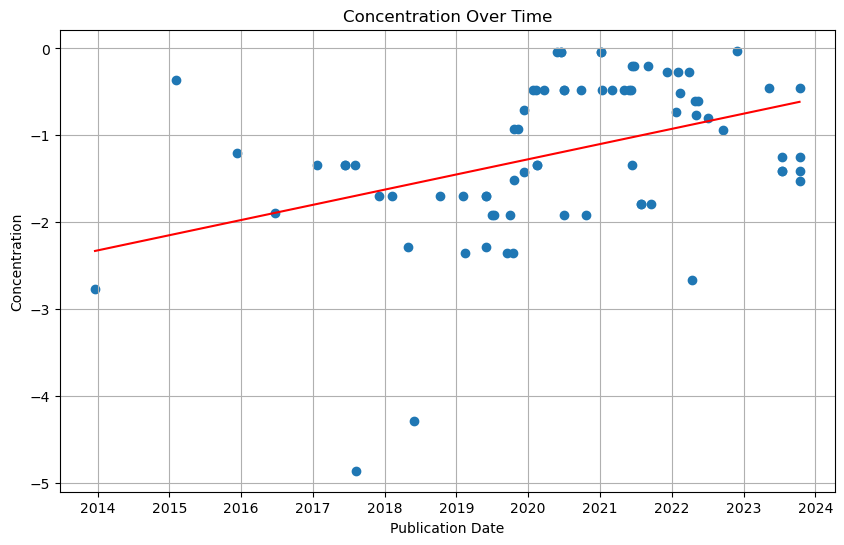

In [27]:
# Sort the DataFrame by 'Publication date'
df2.sort_values('Publication date', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df2['Publication date'], df2['concentration'], marker='o')
plt.plot(df2['Publication date'].loc[valid_rows], preds, 'r', label='OLS')
plt.title('Concentration Over Time')
plt.xlabel('Publication Date')
plt.ylabel('Concentration')
plt.grid(True)
plt.show()

Model selection

In [28]:
original_test(df2['concentration'])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0010284700014000503, z=3.282620552158119, Tau=0.25649122807017544, s=731.0, var_s=49454.333333333336, slope=0.012067279937885929, intercept=-1.97203658929197)

In [29]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Generate or load your DataFrame df2 and the 'concentration' series here

# Initialize an empty list to store the results
results_list = []

# Loop through dates at 1-month intervals
date_range = pd.date_range(start='2012-07-12', end='2023-08-30', freq='M')

for date_value in date_range:
    df2['post_dummy'] = (df2['Publication date'] > date_value).astype(int)
    df2['Publication_ordinal'] = df2['Publication date'].apply(lambda x: x.toordinal())

    X = df2[['Publication_ordinal', 'post_dummy']]
    X = sm.add_constant(X)
    y = df2['concentration']

    valid_rows = y.notna() & X.notna().all(axis=1)
    y = y[valid_rows]
    X = X.loc[valid_rows]

    model = sm.OLS(y, X)
    fit_results = model.fit()
    r2 = fit_results.rsquared

    results_list.append({'date_value': date_value, 'R2': r2})

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='R2', ascending=False)

# Get the dates with the best R^2 values
best_dates = results_df.head(1)['date_value']

print("Dates with the best R^2 values are:", best_dates.tolist())

Dates with the best R^2 values are: [Timestamp('2019-10-31 00:00:00')]


In [30]:
date_range

DatetimeIndex(['2012-07-31', '2012-08-31', '2012-09-30', '2012-10-31',
               '2012-11-30', '2012-12-31', '2013-01-31', '2013-02-28',
               '2013-03-31', '2013-04-30',
               ...
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31'],
              dtype='datetime64[ns]', length=133, freq='M')

In [31]:
for row in results_df.iterrows():
    print(row)

(87, date_value    2019-10-31 00:00:00
R2                       0.368113
Name: 87, dtype: object)
(88, date_value    2019-11-30 00:00:00
R2                       0.349558
Name: 88, dtype: object)
(89, date_value    2019-12-31 00:00:00
R2                       0.327799
Name: 89, dtype: object)
(86, date_value    2019-09-30 00:00:00
R2                       0.321396
Name: 86, dtype: object)
(90, date_value    2020-01-31 00:00:00
R2                       0.297308
Name: 90, dtype: object)
(84, date_value    2019-07-31 00:00:00
R2                       0.285993
Name: 84, dtype: object)
(85, date_value    2019-08-31 00:00:00
R2                       0.285993
Name: 85, dtype: object)
(91, date_value    2020-02-29 00:00:00
R2                       0.274805
Name: 91, dtype: object)
(82, date_value    2019-05-31 00:00:00
R2                       0.254016
Name: 82, dtype: object)
(83, date_value    2019-06-30 00:00:00
R2                       0.254016
Name: 83, dtype: object)
(92, date_value    2

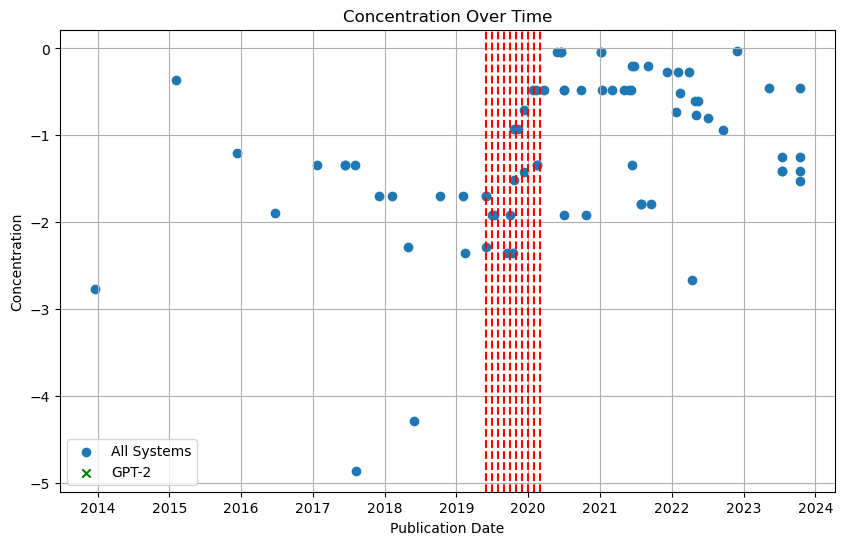

In [32]:
import matplotlib.pyplot as plt

# Extract the top 10 best_dates from the sorted results_df
top_10_best_dates = results_df.head(10)['date_value']

# Sort the DataFrame by 'Publication date'
df2.sort_values('Publication date', inplace=True)

# Identify GPT-2 points
gpt2_points = df2[df2['System'] == 'GPT-2']

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df2['Publication date'], df2['concentration'], marker='o', label='All Systems')

# Add GPT-2 points in a different color
plt.scatter(gpt2_points['Publication date'], gpt2_points['concentration'], color='green', marker='x', label='GPT-2')

# Add vertical lines for the top 10 best_dates
for date in top_10_best_dates:
    plt.axvline(x=date, color='r', linestyle='--')

plt.title('Concentration Over Time')
plt.xlabel('Publication Date')
plt.ylabel('Concentration')
plt.legend()  # Include legend to differentiate GPT-2
plt.grid(True)
plt.show()

In [33]:
df2[df2['System']=='GPT-2']

,index,System,Domain,Task,Organization,Organization Categorization,Authors,Publication date,Reference,Link,...,Compute Sponsor Categorization,Confidence,Abstract,Last Modified,Year,log_compute,cumulative_max,concentration,Publication_ordinal,post_dummy


# Use likelihood ratio test to test significance of structural break in the concentration over time

In [34]:
# Function to fit a linear model and return the log-likelihood
def fit_model(y, x):
    x_const = np.column_stack([np.ones(len(x)), x])
    model = OLS(y, x_const).fit()
    print(model.rsquared)
    return model.llf

# Function to perform the Likelihood Ratio Test for a given break point
# GPT-4's choice of model: fit independent linear models to each segment
def likelihood_ratio_test_piecewise(y, x, break_point):
    # Segment the data
    x1, x2 = x[x < break_point], x[x >= break_point]
    y1, y2 = y[x < break_point], y[x >= break_point]
    
    # Fit models and get log-likelihoods
    llf_full = fit_model(y, x)
    llf_segment1 = fit_model(y1, x1)
    llf_segment2 = fit_model(y2, x2)
    
    # Calculate LR statistic
    lr = -2 * (llf_full - (llf_segment1 + llf_segment2))
    
    # Degrees of freedom (difference in number of parameters between the two models)
    # Model with break point has 5 parameters (2x slope, 2x intercept, 1x break point)
    degs = 3
    
    # Critical value at 1% significance from chi-square distribution
    critical_value = chi2.ppf(0.99, degs)
    
    # Test significance
    is_significant = lr > critical_value

    bic_full = -2 * llf_full + 2 * np.log(len(x))
    bic_broken = -2 * (llf_segment1 + llf_segment2) + 5 * np.log(len(x))
    print(f'BIC: full={bic_full}, broken={bic_broken}')
    
    return lr, is_significant

# Our choice of model: fit lines of equal slope and intercept to each segment
def likelihood_ratio_test_linear(y, x, break_point):
    x1 = (x > break_point).astype(int)
    X = pd.DataFrame({'x1': x1, 'x2': x})

    valid_rows = y.notna() & X.notna().all(axis=1)
    y = y[valid_rows]
    x = x[valid_rows]
    X = X.loc[valid_rows]

    # Fit models and get log-likelihoods
    llf_full = fit_model(y, x)
    llf_broken = fit_model(y, X)
    
    # Calculate LR statistic
    lr = -2 * (llf_full - llf_broken)
    
    # Degrees of freedom (difference in number of parameters between the two models)
    # Model with break point has 3 parameters (slope, intercept, break point)
    degs = 1
    
    # Critical value at 1% significance from chi-square distribution
    critical_value = chi2.ppf(0.99, degs)
    
    # Test significance
    is_significant = lr > critical_value

    bic_full = -2 * llf_full + 2 * np.log(len(x))
    bic_broken = -2 * llf_broken + 3 * np.log(len(x))
    print(f'BIC: full={bic_full}, broken={bic_broken}')
    
    return lr, is_significant

# Fit a step function
def likelihood_ratio_test_step(y, x, break_point):
    x1 = (x > break_point).astype(int)

    valid_rows = y.notna() & x1.notna()
    y = y[valid_rows]
    x1 = x1[valid_rows]

    # Fit models and get log-likelihoods
    llf_full = fit_model(y, np.zeros(len(x)))
    llf_broken = fit_model(y, x1)
    
    # Calculate LR statistic
    lr = -2 * (llf_full - llf_broken)
    
    # Degrees of freedom (difference in number of parameters between the two models)
    # Model with break point adds 1 parameter (break point)
    degs = 1
    
    # Critical value at 1% significance from chi-square distribution
    critical_value = chi2.ppf(0.99, degs)
    
    # Test significance
    is_significant = lr > critical_value

    bic_full = -2 * llf_full + 1 * np.log(len(x))
    bic_broken = -2 * llf_broken + 2 * np.log(len(x))
    print(f'BIC: full={bic_full}, broken={bic_broken}')
    
    return lr, is_significant

In [35]:
df2['Publication_ordinal'] = df2['Publication date'].apply(lambda x: x.toordinal())
df2

,index,System,Domain,Task,Organization,Organization Categorization,Authors,Publication date,Reference,Link,...,Compute Sponsor Categorization,Confidence,Abstract,Last Modified,Year,log_compute,cumulative_max,concentration,Publication_ordinal,post_dummy
0,380.0,Unsupervised High-level Feature Learner,Vision,Image classification,Google,Industry,"Quoc V. Le, Marc'Aurelio Ranzato, Rajat Monga,...",2012-07-12,Building High-level Features Using Large Scale...,https://arxiv.org/abs/1112.6209,...,Industry,Likely,We consider the problem of building high-level...,2023-09-20 19:59:11,2012,17.778151,17.778151,NaN,734696,0
1,366.0,Word2Vec (large),Language,Semantic embedding,Google,Industry,"T Mikolov, I Sutskever, K Chen, GS Corrado",2013-10-16,Distributed Representations of Words and Phras...,https://arxiv.org/abs/1310.4546,...,Industry,NaN,NaN,2023-06-14 14:54:39,2013,17.778151,17.778151,NaN,735157,0
2,362.0,TransE,Other,Entity embedding,Google,Industry - Academia Collaboration,"Antoine Bordes, Nicolas Usunier, Alberto Garci...",2013-12-05,Translating Embeddings for Modeling Multi- rel...,https://papers.nips.cc/paper/2013/hash/1cecc7a...,...,Industry,NaN,NaN,2023-08-03 20:32:27,2013,18.127105,18.127105,NaN,735207,0
3,359.0,DQN,Games,Atari,DeepMind,Industry,"V Mnih, K Kavukcuoglu, D Silver, A Graves",2013-12-19,Playing Atari with Deep Reinforcement Learning,https://arxiv.org/abs/1312.5602,...,Industry,NaN,NaN,2023-06-14 14:57:17,2013,15.361728,18.127105,-2.765377,735221,0
4,348.0,SPPNet,Vision,Image classification,Microsoft,Industry - Academia Collaboration,"Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun",2014-06-18,Spatial Pyramid Pooling in Deep Convolutional ...,https://arxiv.org/abs/1406.4729,...,Industry,NaN,NaN,2023-08-01 10:30:07,2014,18.532754,18.532754,NaN,735402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,NaN,NaN,NaN,NaN,DeepMind,NaN,NaN,2023-10-13,NaN,NaN,...,NaN,NaN,NaN,NaN,2023,23.800029,25.322219,-1.522190,738806,1
114,NaN,NaN,NaN,NaN,Google,NaN,NaN,2023-10-13,NaN,NaN,...,NaN,NaN,NaN,NaN,2023,24.865696,25.322219,-0.456523,738806,1
115,NaN,NaN,NaN,NaN,Meta,NaN,NaN,2023-10-13,NaN,NaN,...,NaN,NaN,NaN,NaN,2023,23.908485,25.322219,-1.413734,738806,1
116,NaN,NaN,NaN,NaN,Microsoft,NaN,NaN,2023-10-13,NaN,NaN,...,NaN,NaN,NaN,NaN,2023,24.068186,25.322219,-1.254033,738806,1


In [36]:
X = df2['Publication_ordinal']
y = df2['concentration']

valid_rows = y.notna() & X.notna()
y = y[valid_rows]
X = X.loc[valid_rows]
valid_dates = df2['Publication date'][valid_rows]
valid_dates.min(), valid_dates.max()

(Timestamp('2013-12-19 00:00:00'), Timestamp('2023-10-13 00:00:00'))

In [37]:
# Initialize an empty list to store the results
results_list = []

# Loop through dates at 1-month intervals
date_range = pd.date_range(start=valid_dates.min(), end=valid_dates.max(), freq='M')

for date_value in date_range:
    print(date_value)
    break_point = date_value.toordinal()
    likelihood_ratio, is_significant = likelihood_ratio_test_step(y, X, break_point)
    results_list.append({'date_value': date_value, 'likelihood_ratio': likelihood_ratio, 'is_significant': is_significant})

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='likelihood_ratio', ascending=False)

# Get the dates with the best likelihood ratios
best_dates = results_df.head(1)['date_value']

print("Dates with the highest likelihood ratios are:", best_dates.tolist())

2013-12-31 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=206.1901335238332, broken=207.4582394838592
2014-01-31 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=206.1901335238332, broken=207.4582394838592
2014-02-28 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=206.1901335238332, broken=207.4582394838592
2014-03-31 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=206.1901335238332, broken=207.4582394838592
2014-04-30 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=206.1901335238332, broken=207.4582394838592
2014-05-31 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=206.1901335238332, broken=207.4582394838592
2014-06-30 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=206.1901335238332, broken=207.4582394838592
2014-07-31 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=206.1901335238332, broken=207.4582394838592
2014-08-31 00:00:00
2.220446049250313e-16
0.03949657284738872
BIC: full=

In [38]:
results_df

,date_value,likelihood_ratio,is_significant
70,2019-10-31,33.623166,True
71,2019-11-30,31.784347,True
72,2019-12-31,29.629595,True
69,2019-09-30,29.077011,True
73,2020-01-31,26.637779,True
...,...,...,...
111,2023-03-31,0.022471,False
112,2023-04-30,0.022471,False
115,2023-07-31,0.005256,False
116,2023-08-31,0.005256,False


Get the range of statistically significant dates (p > 0.01)

In [39]:
results_df[results_df['is_significant']].sort_values(by='date_value')

,date_value,likelihood_ratio,is_significant
53,2018-05-31,7.561380,True
54,2018-06-30,14.470674,True
55,2018-07-31,14.470674,True
56,2018-08-31,14.470674,True
57,2018-09-30,14.470674,True
58,2018-10-31,14.986850,True
59,2018-11-30,14.986850,True
60,2018-12-31,14.986850,True
61,2019-01-31,14.986850,True
62,2019-02-28,18.170928,True


Show final model

In [40]:
date_value = best_dates.tolist()[0]
break_point = date_value.toordinal()

x1 = (X > break_point).astype(int)
x_const = np.column_stack([np.ones(len(x1)), x1])
results = OLS(y, x_const).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          concentration   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     41.18
Date:                Fri, 13 Oct 2023   Prob (F-statistic):           1.18e-08
Time:                        15:28:21   Log-Likelihood:                -84.118
No. Observations:                  76   AIC:                             172.2
Df Residuals:                      74   BIC:                             176.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9509      0.145    -13.412      0.0

In [41]:
preds = results.predict(x_const)

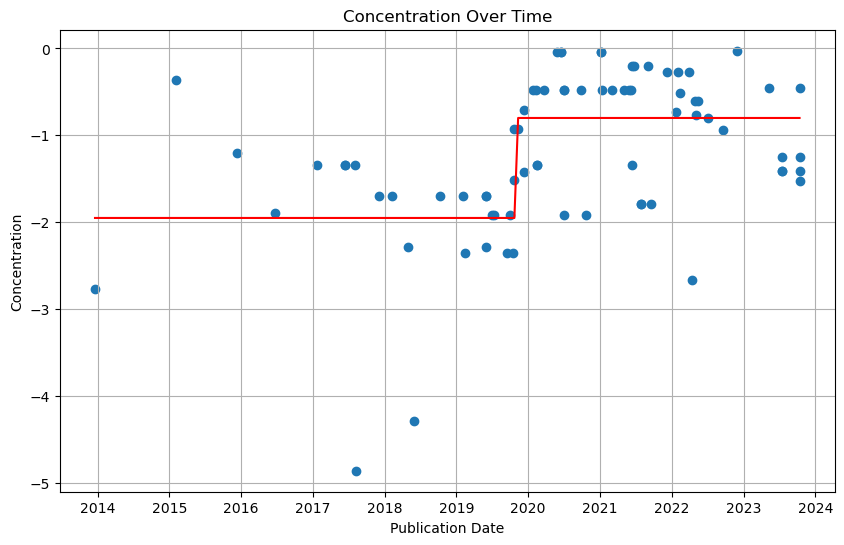

In [42]:
# Sort the DataFrame by 'Publication date'
df2.sort_values('Publication date', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df2['Publication date'], df2['concentration'], marker='o')
plt.plot(df2['Publication date'].loc[valid_rows], preds, 'r', label='OLS')
plt.title('Concentration Over Time')
plt.xlabel('Publication Date')
plt.ylabel('Concentration')
plt.grid(True)
plt.show()